# Dimension Reduction using PCA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\samsung\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = pd.DataFrame(x_train.reshape(60000,-1))
y_train = pd.Series(y_train).astype('object')

In [4]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)

X_train,X_val,Y_train,Y_val = train_test_split(pd.DataFrame(x_scaled),y_train,test_size=0.2,
                                              random_state=123,stratify=y_train)

In [5]:
def reduced_df(X_train,X_val,method,dim):
    X_train_reduced = pd.DataFrame(method.fit_transform(X_train),
                              index=X_train.index)
    X_val_reduced = pd.DataFrame(method.fit_transform(X_val),
                             index=X_val.index)
    
    X_train_reduced = pd.concat([X_train_reduced,Y_train],axis=1)
    X_val_reduced = pd.concat([X_val_reduced,Y_val],axis=1)
    colnames = ["PC" + str(i) for i in range(1,dim+1)]
    colnames.append('class')
    X_train_reduced.columns = colnames
    X_val_reduced.columns = colnames
    return X_train_reduced,X_val_reduced

In [16]:
pca = PCA(n_components=X_train.shape[1],random_state=123)
pca.fit(X_train)
sum(pca.explained_variance_ratio_.cumsum()<0.7)

95

In [17]:
pca = PCA(n_components=95,random_state=123)
pca_train, pca_val= reduced_df(X_train,X_val,pca,95)

# Clustering

In [31]:
# Kmeans
from sklearn.cluster import KMeans

# Hierarchical CLustering
import fastcluster
from scipy.cluster.hierarchy import dendrogram,cophenet,fcluster
from scipy.spatial.distance import pdist

# DBSCAN
from sklearn.cluster import DBSCAN
#import hdbscan

## K-means

In [66]:
pca_df_kmeans = pca_train.copy()

In [47]:
def kmeans_inertia(start,end,sep,reduced_df):
    k_list=[]
    n_clus_list = np.arange(start,end,sep).astype('int')
    iner = pd.DataFrame(data=[],index=n_clus_list,columns=['inertia'])
    for n in n_clus_list:
        k = KMeans(n_clusters=n,n_init=5,random_state=123)
        k.fit(reduced_df)
        iner.loc[n] = k.inertia_
        k_list.append(k)
    return iner,k_list

In [51]:
kmeans_iner, kmeans_list = kmeans_inertia(4,20,2,pca_df_kmeans)

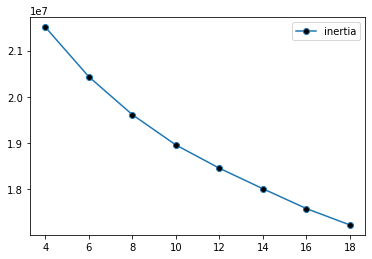

In [57]:
kmeans_iner.plot(style='.-',marker='o', markerfacecolor='black')

In [75]:
k8 = kmeans_list[2]
pca_df_kmeans['cluster'] = k8.labels_

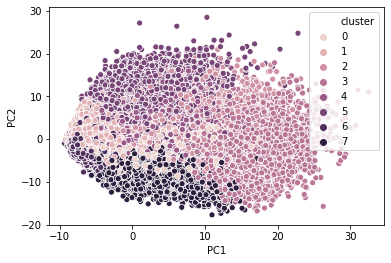

In [76]:
sns.scatterplot(x='PC1',y='PC2',hue='cluster',legend='full',data=pca_df_kmeans)

## Hierarchical Clustering

In [98]:
pca_df_hc = pca_train.copy()
pca_df_hc = pca_df_hc.iloc[0:1000,:]

In [100]:
Z = fastcluster.linkage_vector(pca_df_hc.iloc[:,0:20],method='ward',metric='euclidean')
Z_df = pd.DataFrame(Z, columns=['cl_1','cl_2','dist','new_cl_size'])

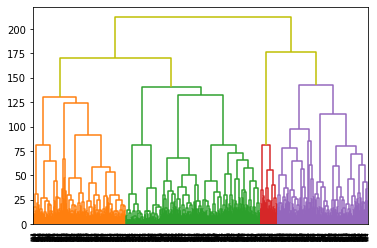

In [85]:
dend = dendrogram(Z, above_threshold_color='y',orientation='top')

In [101]:
dist_thres = 160
hclust = fcluster(Z,dist_thres,criterion='distance') # cut tree
hclust_df = pd.DataFrame(hclust, index=pca_df_hc.index, columns=['cluster'])
pca_df_hc['cluster'] = hclust_df['cluster']
print('Number of clusters :', hclust_df['cluster'].nunique())

Number of clusters : 4


## DBSCAN

In [103]:
pca_df_dbscan = pca_train.copy()

In [ ]:
sns.scatterplot(x='PC1',y='PC2',hue='cluster',legend='full',data=pca_df_dbscan)

In [ ]:
db = DBSCAN(eps=10,min_samples=6,leaf_size=30)

dbscan = db.fit_predict(pca_df_dbscan.iloc[:,0:30])
dbscan_df = pd.DataFrame(dbscan, index=X_train.index, columns=['cluster'])
pca_df_dbscan['cluster'] = dbscan_df['cluster']

In [ ]:
sns.scatterplot(x='PC1',y='PC2',hue='cluster',legend='full',data=pca_df_dbscan)